<a href="https://colab.research.google.com/github/aryankargwal/pytorch-mask-rcnn/blob/main/mask_rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports
import torch
import torchvision

In [ ]:
# Importing the pre-trained model from torchvision
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained = True)
model.eval()

In [ ]:
# Adding the classes list
coco_classes = [
                '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',  'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
len(coco_classes)

91

In [ ]:
# Imports for Image and Pre-processing
from PIL import Image
from torchvision import transforms as T
import numpy as np
# Following are required to load images from URL
import requests 
from io import BytesIO

In [ ]:
def preds(image_path, threshold, url = False):
  # Loading Image
  if url: # in case of URL
    response = requests.get(img_path)
    img = Image.open(BytesIO(response.content))
  else: # in case of Local
    img = Image.open(image_path)
  # Turning image to torch tensor
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  pred = model([img])
  # Getting the masks
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]
  masks = (pred[0]['masks'] > 0.5).squeeze().detach().cpu().numpy()
  masks = masks[:pred_t+1]
  pred_class = [coco_classes[i] for i in list(pred[0]['labels'].cpu().numpy())]
  pred_class = pred_class[:pred_t+1]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
  pred_boxes = pred_boxes[:pred_t+1]
  return masks, pred_class, pred_boxes

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # For high res images

In [ ]:
import cv2 as cv
import random

In [ ]:
from urllib.request import urlopen
def url_to_image(url, readFlag=cv.IMREAD_COLOR):
  resp = urlopen(url) # We want to convert URL to cv2 image here, so we can draw the mask and bounding boxes
  image = np.asarray(bytearray(resp.read()), dtype="uint8")
  image = cv.imdecode(image, readFlag)
  return image

In [ ]:
# Randomized colours for the Masks
def random_color_masks(image):
  colors = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180], [250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image==1], g[image==1], b[image==1] = colors[random.randrange(0, 10)]
  colored_mask = np.stack([r,g,b], axis=2)
  return colored_mask

In [ ]:
def instance_segmentation(img_path, threshold=0.5, rect_th=3,
                          text_size=3, text_th=3, url=False):
  masks, pred_cls, boxes = preds(img_path, threshold=threshold, url=url)
  if url:
    img = url_to_image(img_path) # URL
  else: # Local image
    img = cv.imread(img_path)
  img = cv.cvtColor(img, cv.COLOR_BGR2RGB) # For working with RGB images instead of BGR
  for i in range(len(masks)):
    rgb_mask = random_color_masks(masks[i])
    img = cv.addWeighted(img, 1, rgb_mask, 0.5, 0)
    cv.putText(img, pred_cls[i], boxes[i][0], cv.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), thickness=text_th)
  return img, pred_cls, masks[i]

In [ ]:
!wget https://www.extremetech.com/wp-content/uploads/2011/07/cars-driving.jpg -O car.jpg

--2021-07-19 17:33:19--  https://www.extremetech.com/wp-content/uploads/2011/07/cars-driving.jpg
Resolving www.extremetech.com (www.extremetech.com)... 23.212.249.75, 23.212.249.88
Connecting to www.extremetech.com (www.extremetech.com)|23.212.249.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1833807 (1.7M) [image/jpeg]
Saving to: ‘car.jpg’

car.jpg             100%[===================>]   1.75M  --.-KB/s    in 0.01s   

2021-07-19 17:33:19 (122 MB/s) - ‘car.jpg’ saved [1833807/1833807]



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


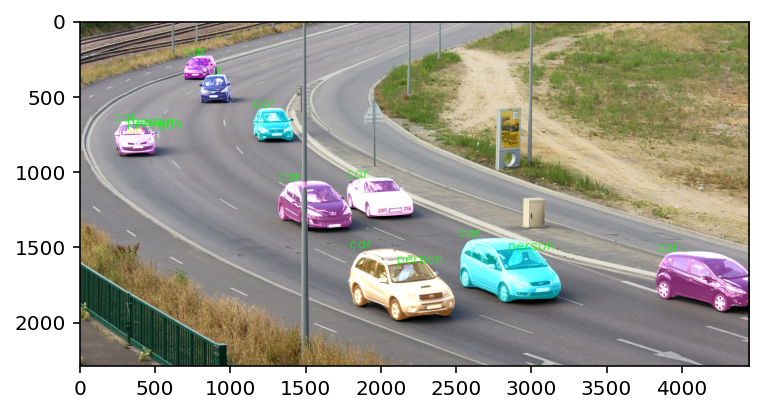

In [ ]:
img, pred_classes, masks = instance_segmentation('./car.jpg', rect_th=5, text_th=4)
plt.imshow(img)